# Prepare

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import binomtest, ttest_ind, chi2_contingency, chi2, fisher_exact
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.power as pwr
path = "D:\\Kadir\\Codes\\kdr_data_science_py\\data\\"

In [38]:
session_times = pd.read_csv(path + "\\web_page_data.csv")
session_times.iloc[:, 1] = session_times.iloc[:, 1] * 100
four_sessions = pd.read_csv(path + "\\four_sessions.csv")
click_rate = pd.read_csv(path + "\\click_rates.csv")

### A/B Testing

<Figure size 800x600 with 0 Axes>

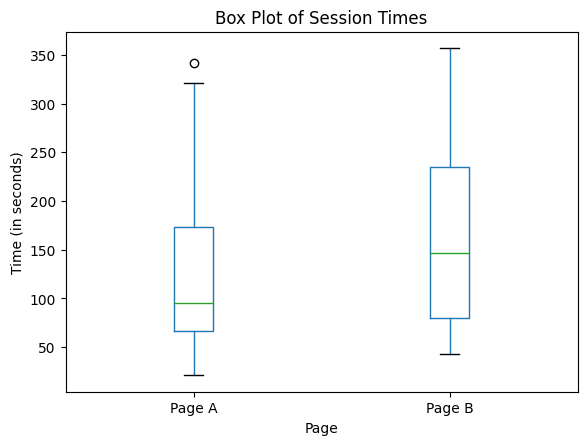

In [39]:
# Create a box plot
plt.figure(figsize=(8, 6))
box_plot = session_times.boxplot(column='Time', by='Page', grid=False)

# Set labels and title
plt.xlabel('Page')
plt.ylabel('Time (in seconds)')
plt.title('Box Plot of Session Times')

# Remove automatic subplot title
plt.suptitle("")

# Show the plot
plt.show()

In [40]:
# Calculate the mean for Page A
mean_a = session_times.loc[session_times['Page'] == 'Page A', 'Time'].mean()

# Calculate the mean for Page B
mean_b = session_times.loc[session_times['Page'] == 'Page B', 'Time'].mean()

# Calculate the mean difference
mean_difference = mean_b - mean_a

print("Mean Difference:", mean_difference)

Mean Difference: 35.66666666666667


In [41]:
# Permutation test example with stickiness

# perm_fun is a custom function defined to calculate the mean difference in session times between Group B and Group A.
# x is the vector of session times.
# nA is the number of observations in Group A.
# nB is the number of observations in Group B.
# The function first calculates the total number of observations n by adding nA and nB.
# It then randomly samples nB indices from 1 to n to represent the indices of observations in Group B (idx_b).
# idx_a is calculated as the indices that are not in idx_b, representing Group A.
# The function computes the mean difference between session times of Group B and Group A using the calculated indices.
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_b = np.random.choice(np.arange(n), size=nB, replace=False)
    idx_a = np.setdiff1d(np.arange(n), idx_b)
    mean_diff = np.mean(x[idx_b]) - np.mean(x[idx_a])
    return mean_diff

np.random.seed(1)
num_iterations = 1000
perm_diffs = np.zeros(num_iterations)

for i in range(num_iterations):
    perm_diffs[i] = perm_fun(session_times['Time'], 21, 15)

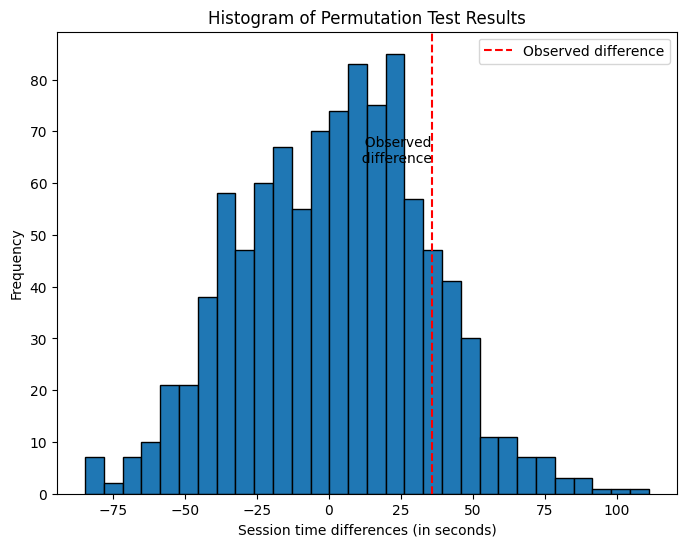

P-value: 0.138


In [42]:

# Set up the plot
plt.figure(figsize=(8, 6))
plt.hist(perm_diffs, bins=30, edgecolor='black')
plt.xlabel('Session time differences (in seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Permutation Test Results')

# Add a vertical line for the observed difference
observed_diff = mean_b - mean_a
plt.axvline(x=observed_diff, color='red', linestyle='dashed', linewidth=1.5, label='Observed difference')
plt.legend()

# Add text annotation for the observed difference
plt.text(observed_diff, plt.ylim()[1] - 20, '  Observed\n  difference', verticalalignment='top', horizontalalignment='right')

# Show the plot
plt.show()

# Calculate the p-value
p_value = np.mean(perm_diffs > observed_diff)
print("P-value:", p_value)

### Statistical Significance and P-Values

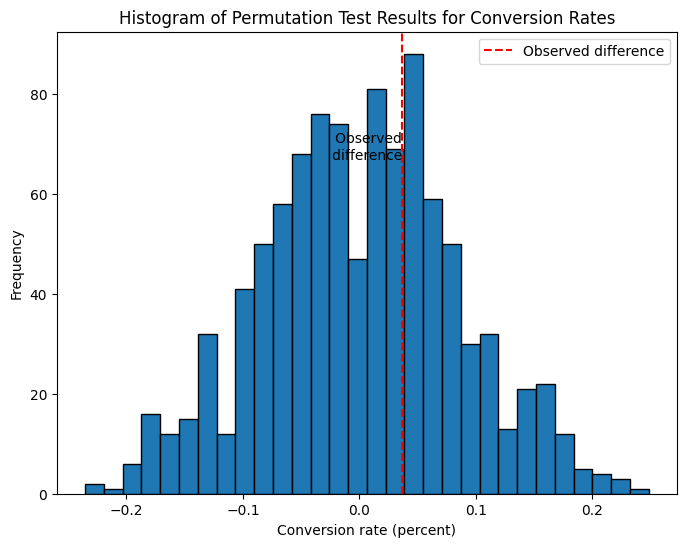

In [43]:

# Observed percentage difference calculation
obs_pct_diff = 100 * ((200 / 23739) - (182 / 22588))

# Generating the conversion data
conversion = np.concatenate((np.zeros(45945), np.ones(382)))

# Permutation test iterations
num_iterations = 1000
perm_diffs = np.zeros(num_iterations)
for i in range(num_iterations):
    perm_diffs[i] = 100 * perm_fun(conversion, 23739, 22588)

# Creating the histogram plot
plt.figure(figsize=(8, 6))
plt.hist(perm_diffs, bins=30, edgecolor='black')
plt.xlabel('Conversion rate (percent)')
plt.ylabel('Frequency')
plt.title('Histogram of Permutation Test Results for Conversion Rates')

# Adding a vertical line for the observed difference
plt.axvline(x=obs_pct_diff, color='red', linestyle='dashed', linewidth=1.5, label='Observed difference')
plt.legend()

# Adding text annotation for the observed difference
plt.text(obs_pct_diff, plt.ylim()[1] - 20, '   Observed\n   difference', verticalalignment='top', horizontalalignment='right')

# Show the plot
plt.show()

In [44]:
# Print the observed difference
print("Observed difference:", obs_pct_diff)

Observed difference: 0.03675791182059275


In [45]:
# Calculate the p-value using permutation test results
p_value_perm = np.mean(perm_diffs > obs_pct_diff)
print("P-value from permutation test:", p_value_perm)

P-value from permutation test: 0.34


In [46]:
# Perform a one-sample proportion test using the binom_test function
successes = [200, 182]
total_trials = [23739, 22588]
p_value_binom = binomtest(successes[0], n=total_trials[0], p=successes[0] / sum(successes), alternative='greater')
print("P-value from binomial test:", p_value_binom)

P-value from binomial test: BinomTestResult(k=200, n=23739, alternative='greater', statistic=0.008424954715868403, pvalue=1.0)


### T-tests

In [47]:
# Perform a one-sided t-test
page_a_times = session_times[session_times['Page'] == 'Page A']['Time']
page_b_times = session_times[session_times['Page'] == 'Page B']['Time']

t_statistic, p_value = ttest_ind(page_a_times, page_b_times, alternative='less')

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -1.1237042154424814
p-value: 0.1345051218196303


### ANOVA - F-Statistics

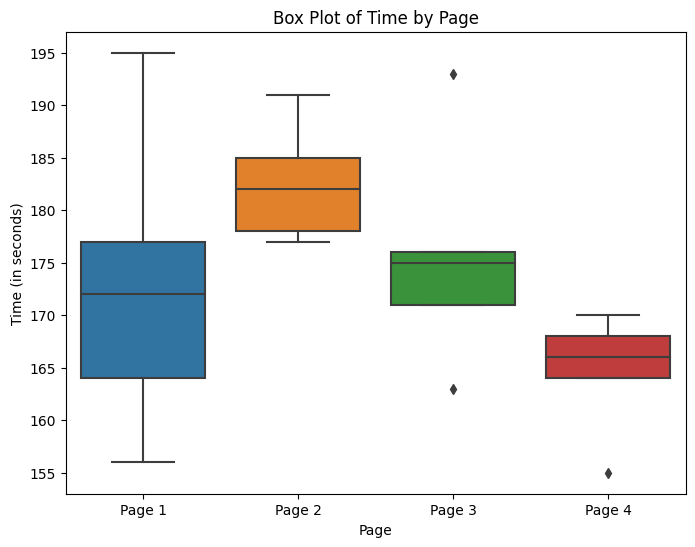

In [48]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Page', y='Time', data=four_sessions)
plt.xlabel('Page')
plt.ylabel('Time (in seconds)')
plt.title('Box Plot of Time by Page')

# Show the plot
plt.show()

In [49]:
# Perform ANOVA using statsmodels
model = ols('Time ~ Page', data=four_sessions).fit()
anova_table = sm.stats.anova_lm(model)

print("ANOVA Table:")
print(anova_table)

ANOVA Table:
            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [50]:
# Calculate the F-statistic using statsmodels
f_statistic = anova_table['F'][0]

print("F-statistic:", f_statistic)

F-statistic: 2.7398253419014527


### Chi-Square Test

In [51]:
# Create a contingency table
clicks = click_rate.pivot(index='Headline', columns='Click', values='Rate')

# Perform a chi-square test with resampling
chi2_observed = chi2_contingency(clicks)
chi2_statistic = chi2_observed[0]
chi2_p_value = chi2_observed[1]

print("Chi-Square Test:")
print("Observed Frequencies:\n", clicks)
print("Chi-Square Statistic:", chi2_statistic)
print("P-value:", chi2_p_value)

Chi-Square Test:
Observed Frequencies:
 Click       Click  No-click
Headline                   
Headline A     14       986
Headline B      8       992
Headline C     12       988
Chi-Square Statistic: 1.6659394708658917
P-value: 0.4347562562343731


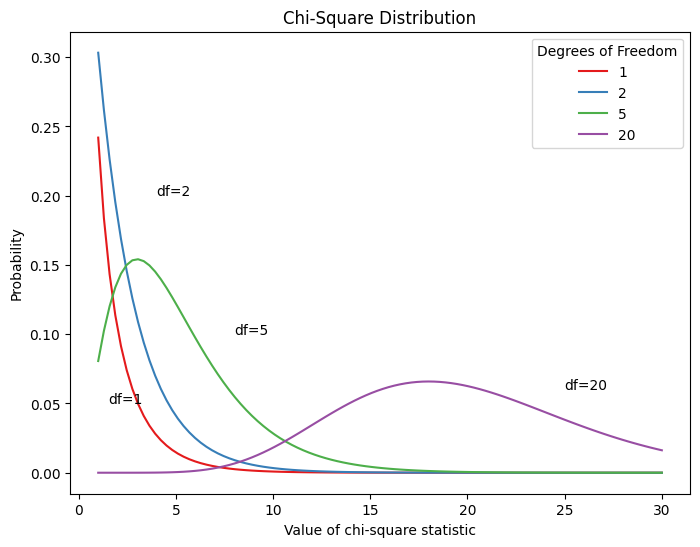

In [52]:
# Creating the chi-square distribution figure with custom colors
x = np.linspace(1, 30, num=100)
dfs = [1, 2, 5, 20]
colors = sns.color_palette("Set1", n_colors=len(dfs))

chi_values = np.array([chi2.pdf(x, df) for df in dfs]).T

chi_df = pd.DataFrame(data=chi_values, columns=dfs, index=x)
chi_df = chi_df.stack().reset_index()
chi_df.columns = ['x', 'df', 'p']

plt.figure(figsize=(8, 6))
sns.lineplot(x='x', y='p', hue='df', data=chi_df, style='df', dashes=False, palette=colors)
plt.text(25, 0.06, 'df=20', size=10)
plt.text(8, 0.1, 'df=5', size=10)
plt.text(4, 0.2, 'df=2', size=10)
plt.text(1.5, 0.05, 'df=1', size=10)
plt.xlabel('Value of chi-square statistic')
plt.ylabel('Probability')
plt.title('Chi-Square Distribution')
plt.legend(title='Degrees of Freedom')
plt.show()

### Power and Sample Size

In [53]:
# Example 1: Find Sample Size
effect_size1 = pwr.TTestIndPower().solve_power(effect_size=0.0121, alpha=0.05, power=0.8, alternative='larger')
print("Sample Size (Example 1):", round(effect_size1))

Sample Size (Example 1): 84456


In [54]:
# Example 2: Find Sample Size
effect_size2 = pwr.TTestIndPower().solve_power(effect_size=0.0165, alpha=0.05, power=0.8, alternative='larger')
print("Sample Size (Example 2):", round(effect_size2))

Sample Size (Example 2): 45419
